In [1]:
import numpy as np
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.optim.lr_scheduler import StepLR
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import r2_score
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
from datetime import datetime
from sklearn.preprocessing import StandardScaler
import os
from helper import train_VAE 
from VAE_model import VAE
import json
plt.rcParams['figure.figsize'] = [8,5]
plt.rcParams['figure.dpi']=200
device='cpu'

In [4]:
X_train = pd.read_csv('../../datasets/Toy/X_train.csv',index_col=0)  
X_test = pd.read_csv('../../datasets/Toy/X_test.csv',index_col=0)  
y_train = pd.read_csv('../../datasets/Toy/y_train.csv',index_col=0)  
y_test = pd.read_csv('../../datasets/Toy/y_test.csv',index_col=0) 
X_train_con=X_train.drop(columns=['x1'])
X_test_con=X_test.drop(columns=['x1'])


random_seed = 42
X_train_sample = X_train_con.sample(n=300, random_state=random_seed)
y_train_sample = y_train.loc[X_train_sample.index]

X_test_sample = X_test_con.sample(n=300, random_state=random_seed)
X_test_all_sample=X_test.loc[X_test_sample.index]
y_test_sample = y_test.loc[X_test_sample.index]

In [5]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_con)
X_test_scaled = scaler.transform(X_test_con)
X_test_scaled_sample = scaler.transform(X_test_sample)

In [6]:
load_model="Toy_No_freeze_z_and_zz_to_y_R2_0_9891348218500815"
with open(f'Final/Config_{load_model}.json') as country_json1:
          config = json.load(country_json1)
          print(config)
config_params = config['config']
beta = config['beta']
lr = config['lr']
batch_size = config['batch_size']
num_epochs = config['num_epochs']

x_dim = config_params['x_dim']
z_dim = config_params['z_dim']
zz_dim = config_params['zz_dim']
encoder_z_layers = config_params['encoder_z_layers']
encoder_zz_layers = config_params['encoder_zz_layers']
decoder_layers = config_params['decoder_layers']
fc_z_to_y_layers = config_params['fc_z_to_y_layers']
b1 = beta['b1']
b2 = beta['b2']
b3 = beta['b3']
b4 = beta['b4']
b5 = beta['b5']
model=VAE(x_dim, z_dim, zz_dim, encoder_z_layers, encoder_zz_layers, decoder_layers, fc_z_to_y_layers,z_and_zz_to_y=False)

{'config': {'x_dim': 5, 'z_dim': 3, 'zz_dim': 1, 'encoder_z_layers': [64, 64, 64], 'encoder_zz_layers': [10, 10], 'decoder_layers': [64, 64, 64, 5], 'fc_z_to_y_layers': [32, 32, 32, 1]}, 'beta': {'b1': 10000, 'b2': 1, 'b3': 1, 'b4': 10000, 'b5': 1}, 'lr': 0.001, 'batch_size': 1024, 'num_epochs': 500}


In [12]:
train_ds = TensorDataset(torch.Tensor(X_train_scaled), torch.Tensor(y_train.to_numpy()))
test_ds = TensorDataset(torch.Tensor(X_test_scaled), torch.Tensor(y_test.to_numpy()))

In [13]:
train_loader = DataLoader(train_ds, batch_size=config["batch_size"], shuffle=True)

test_loader = DataLoader(test_ds, batch_size=config["batch_size"])

In [11]:
model = torch.load(f"../Toy/Final/{load_model}_model.zip",map_location=torch.device('cpu'))
model.eval()

VAE(
  (encoder_z_seq): Sequential(
    (0): Linear(in_features=5, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
  )
  (fc21): Linear(in_features=64, out_features=3, bias=True)
  (fc22): Linear(in_features=64, out_features=3, bias=True)
  (encoder_zz_seq): Sequential(
    (0): Linear(in_features=3, out_features=10, bias=True)
    (1): ReLU()
    (2): Linear(in_features=10, out_features=10, bias=True)
    (3): ReLU()
  )
  (fcz21): Linear(in_features=10, out_features=1, bias=True)
  (fcz22): Linear(in_features=10, out_features=1, bias=True)
  (decoder): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=64, bias=True)
    (5): ReLU()
    (6): Linear(in_features=64, out_features=5, bias

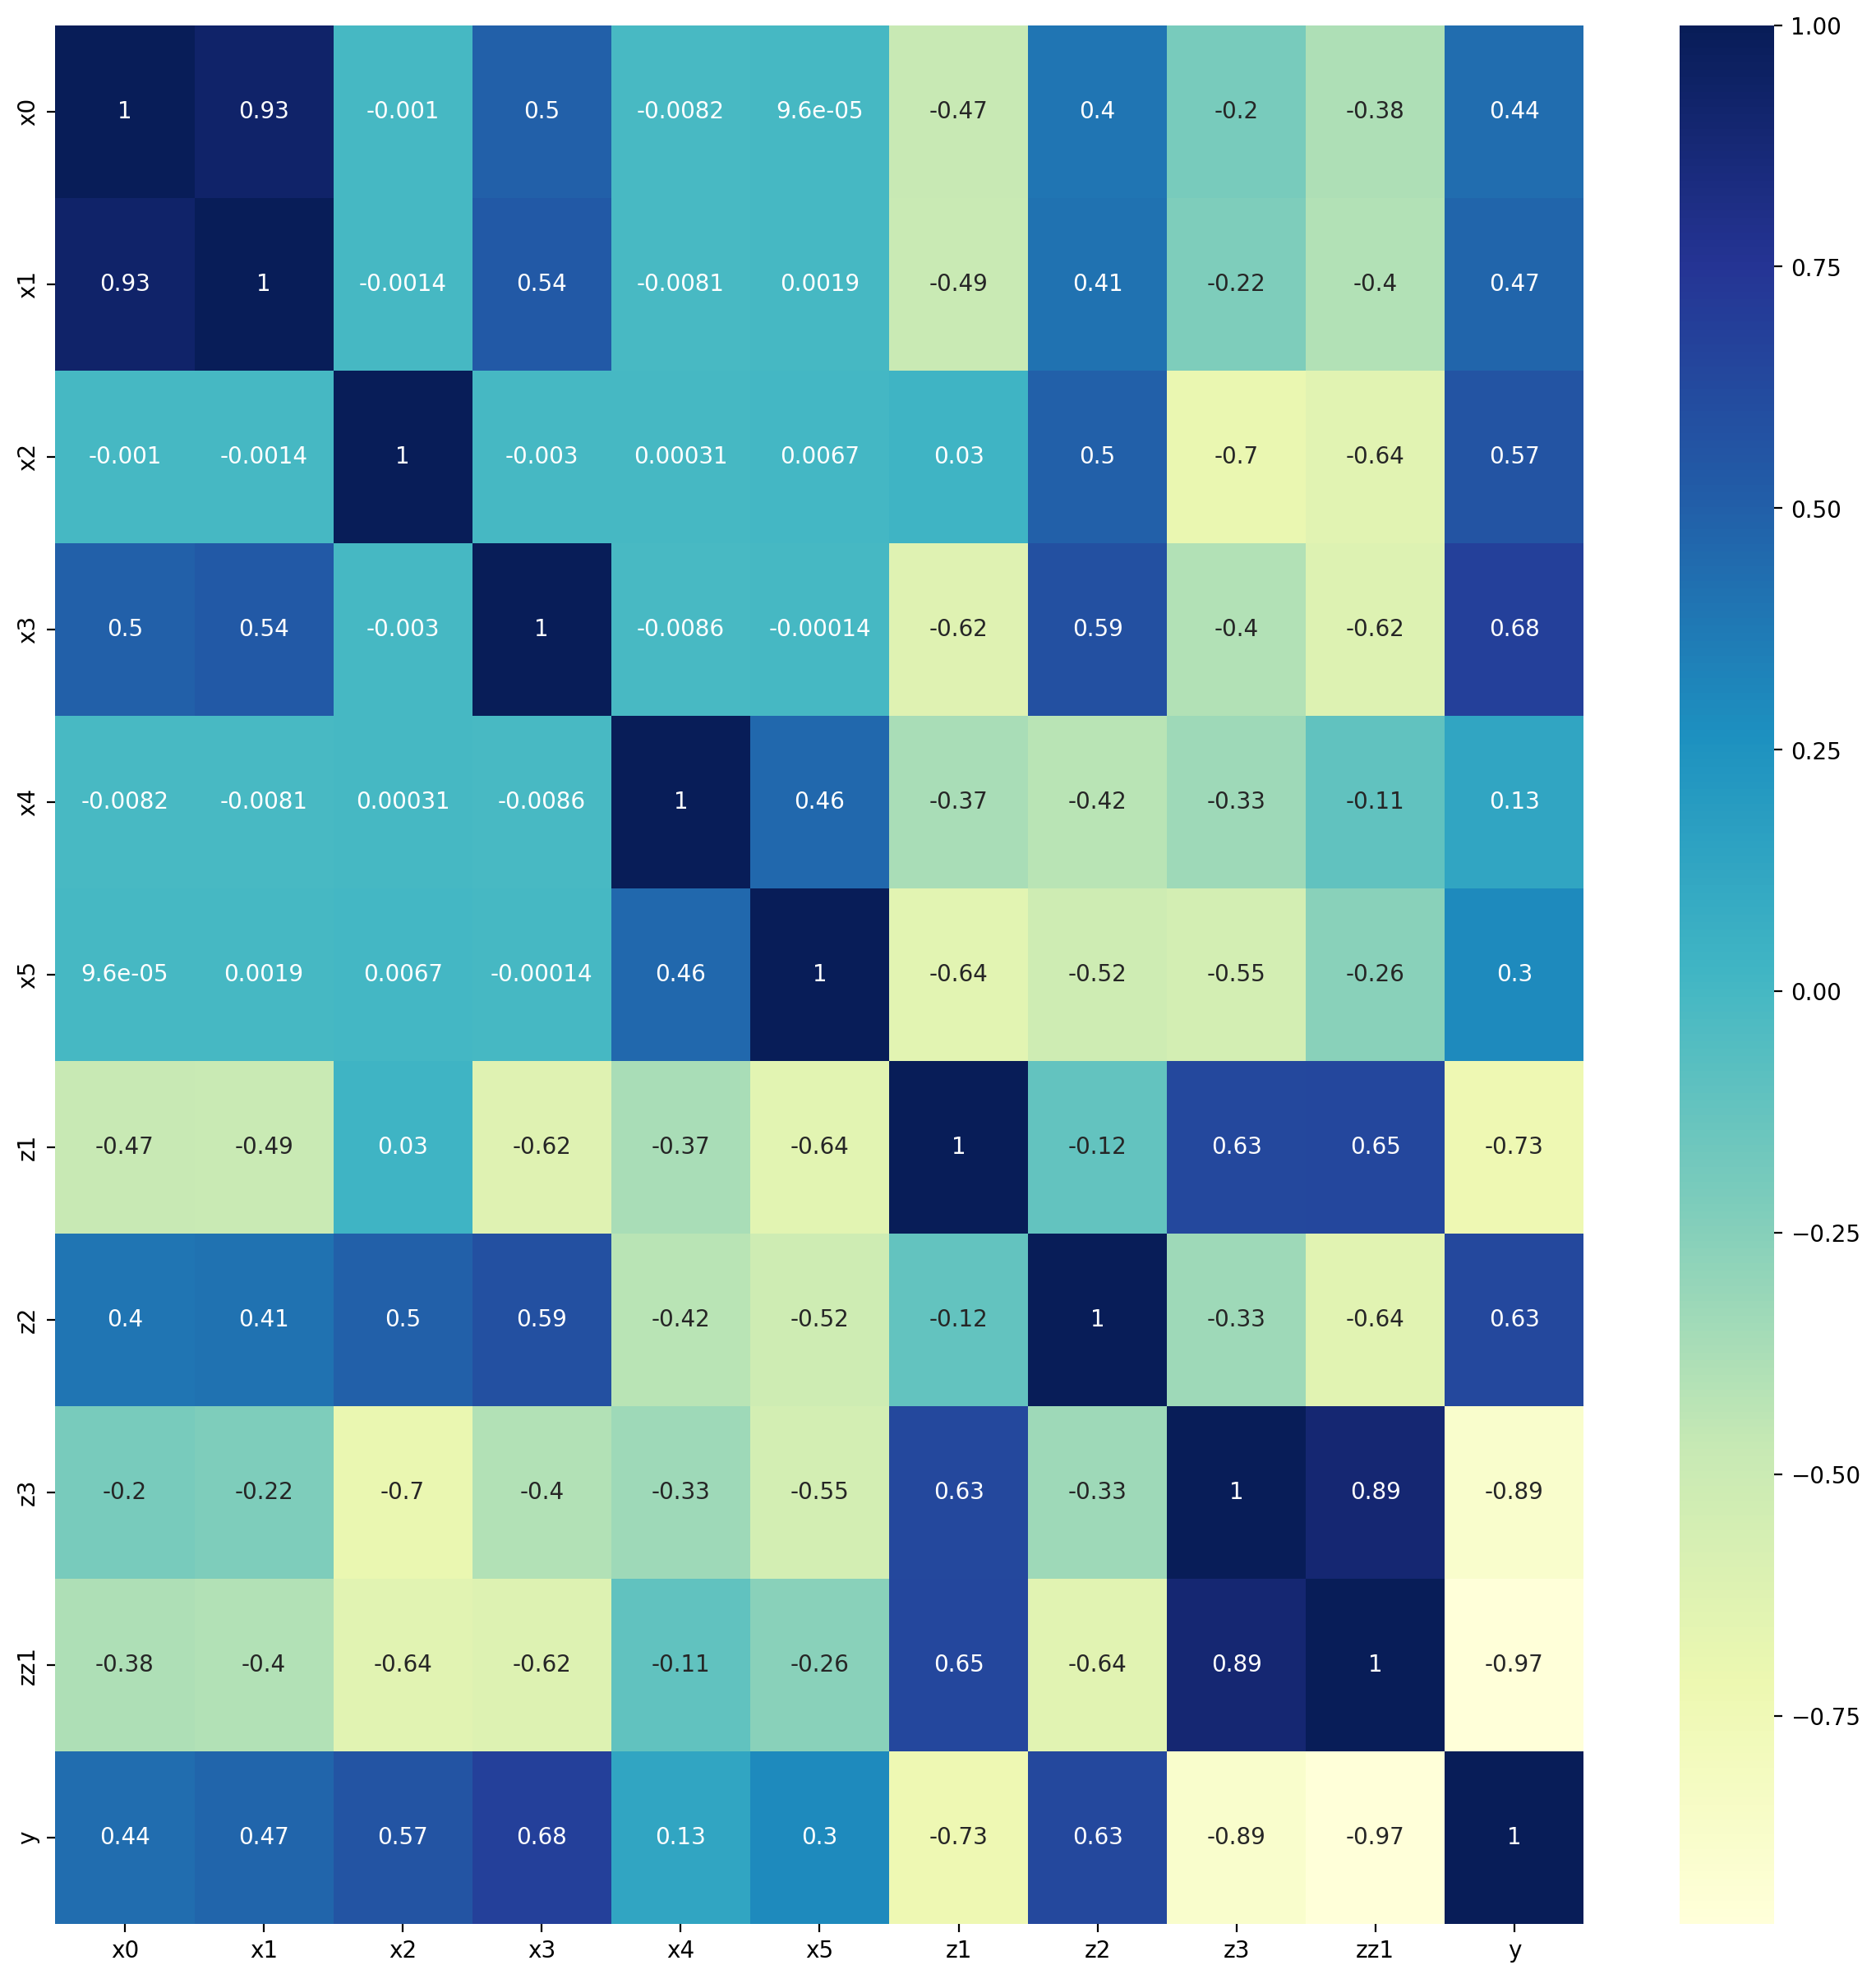

In [14]:
recon_x_subset, mu_z, log_z, mu_zz, log_zz,_ = model(torch.from_numpy(X_test_scaled).float().to(device))
# Reparameterize to get the estimated z values
z_est_subset = model.reparameterize(mu_z, log_z,1)
zz_est_subset = model.reparameterize(mu_zz, log_zz,1)


z_columns = [f'z{i+1}' for i in range(z_dim)]
zz_columns = [f'zz{i+1}' for i in range(zz_dim)]

# Convert your tensor to a dataframe
zz_est_df = pd.DataFrame(zz_est_subset.cpu().detach().numpy(), columns=zz_columns)
z_est_df = pd.DataFrame(z_est_subset.cpu().detach().numpy(), columns=z_columns)
# Reset the index of both dataframes
X_test_reset = pd.DataFrame(X_test).reset_index(drop=True)
z_est_df_reset = z_est_df.reset_index(drop=True)
zz_est_df = zz_est_df.reset_index(drop=True)
y_test_reset=  pd.DataFrame(y_test).reset_index(drop=True)


# Concatenate the dataframes
df = pd.concat([X_test_reset, z_est_df_reset,zz_est_df,y_test_reset], axis=1)

plt.figure(figsize=(15, 15))
# Compute the correlation matrix
corr = df.corr()

# Generate a heatmap
sns.heatmap(corr, cmap="YlGnBu",annot=True)
# Save the figure
#pic_name_heat = create_picture_name(config, "heatmap")
#print(pic_name_heat)
#plt.savefig(os.path.join(path, pic_name_heat))
plt.show()

In [15]:
class masked_model():
    def __init__(self, model):
        self.model = model
    
    def forward(self,x):
        _,_,_,_,_,prediction=model(x)
        return prediction

In [16]:
mod=masked_model(model)

In [25]:
from matplotlib.colors import ListedColormap, Normalize
from matplotlib.cm import ScalarMappable
from matplotlib.lines import Line2D
import random

def plot_prediction_vs_truth(model, X_s, X, y, title="Model Predictions vs Truth", num_points=300):
    device = next(model.parameters()).device

    fig, ax = plt.subplots()

    # Fetch CGPA values directly from DataFrame X
    x1_values = X.loc[:, 'x1'].values
    normalized_x1 = (x1_values - np.min(x1_values)) / (np.max(x1_values) - np.min(x1_values))
    cmap = plt.get_cmap('coolwarm')  # Using 'coolwarm' colormap. You can choose any appropriate colormap.

    with torch.no_grad():
        model = model.eval()
        _,_,_,_,_,predictions = model(torch.tensor(X_s, dtype=torch.float, device=device))
        predictions=predictions.cpu().numpy()

    # Ensure all arrays have the same length before looping
    assert len(y) == len(X_s) == len(normalized_x1), "Input arrays must have the same length"
    
    indices = range(len(X_s))
    
    # Sample num_points indices
    if num_points and num_points < len(indices):
        indices = random.sample(indices, num_points)
    
    for i in indices:
        color = cmap(normalized_x1[i])
        plt.scatter(y.iloc[i], predictions[i], color=color, alpha=0.7)

    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=2)

    plt.xlabel("Truth")
    plt.ylabel("Prediction")
    plt.title(title)
    
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    
    # Define the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='x1')

    # Customize colorbar ticks
    min_val, max_val = np.min(x1_values), np.max(x1_values)
    tick_values = np.linspace(min_val, max_val, num=6)  # 6 ticks
    normed_ticks = (tick_values - min_val) / (max_val - min_val)  # Normalize tick values (0 to 1 range)
    cbar.set_ticks(normed_ticks)
    
    # Set tick labels with two decimal places
    cbar.set_ticklabels(['{:.2f}'.format(val) for val in tick_values])

    plt.show()



In [26]:
class RMSELoss(nn.Module):
    def __init__(self):
        super().__init__()
        self.mse = nn.MSELoss()
        
    def forward(self,yhat,y):
        return torch.sqrt(self.mse(yhat,y))
criterion = RMSELoss()

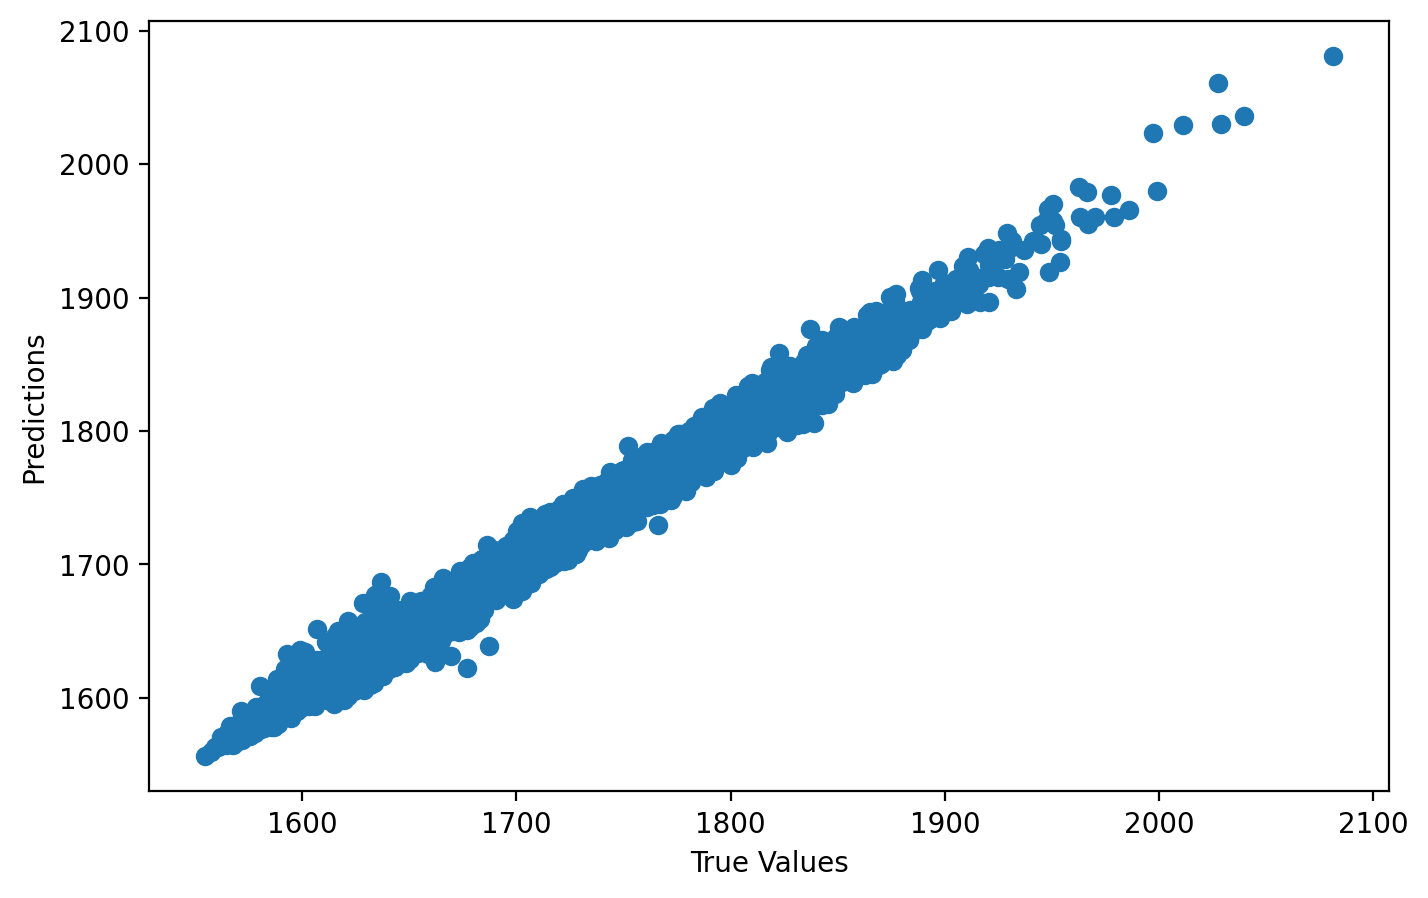

R^2 score: 0.9890448442428876
Train_loss: 5.332045030593872
Test_loss: 5.398017263412475


In [27]:
def plot_predictions_VAE(net, data_loader, device):
    y_true = []
    y_pred = []
    with torch.no_grad():
        for inputs, targets in data_loader:
            inputs, targets = inputs.to(device), targets.to(device).view(-1, 1)
            outputs = net(inputs)
            y_true.extend(targets.cpu().numpy())
            y_pred.extend(outputs.cpu().numpy())

    plt.scatter(y_true, y_pred)
    plt.xlabel("True Values")
    plt.ylabel("Predictions")
    plt.show()

def r_squared(y_true, y_pred):
    y_bar = np.mean(y_true)
    ss_tot = np.sum((y_true - y_bar) ** 2)
    ss_res = np.sum((y_true - y_pred) ** 2)
    r2 = 1 - (ss_res / ss_tot)
    return r2
plot_predictions_VAE(mod.forward, test_loader, device)
y_true = np.array(y_test,dtype=object)

r2_Scores=0
for _ in range(10):
    y_pred = mod.forward(torch.Tensor(X_test_scaled).to(device))
    y_pred=y_pred.cpu().detach().numpy()
    r2 = r2_score(y_test, y_pred)
    r2_Scores+=r2
print("R^2 score:", r2_Scores/10)
y_train_tensor = torch.Tensor(y_train.values).to(device)
y_test_tensor = torch.Tensor(y_test.values).to(device)
trls=0
tels=0
for _ in range(10):
    trls+=criterion(mod.forward(torch.Tensor(X_train_scaled).to(device)),y_train_tensor).item()
    tels+=criterion(mod.forward(torch.Tensor(X_test_scaled).to(device)),y_test_tensor).item()
    

print("Train_loss:",trls/10)
print("Test_loss:",tels/10)


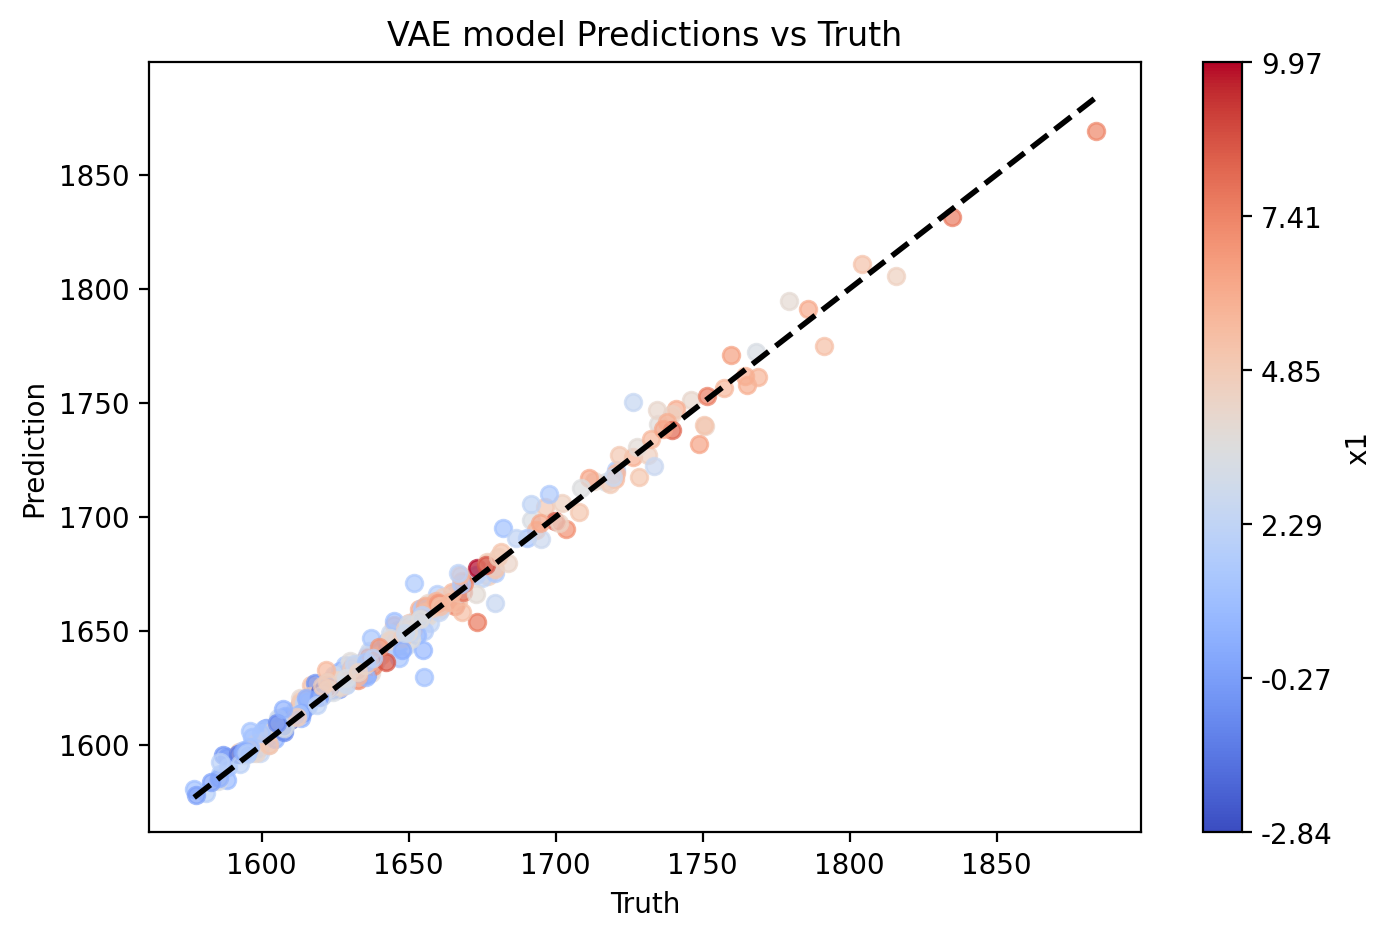

In [31]:
plot_prediction_vs_truth(model,X_test_scaled_sample,X_test_all_sample,y_test_sample,title="VAE model Predictions vs Truth")

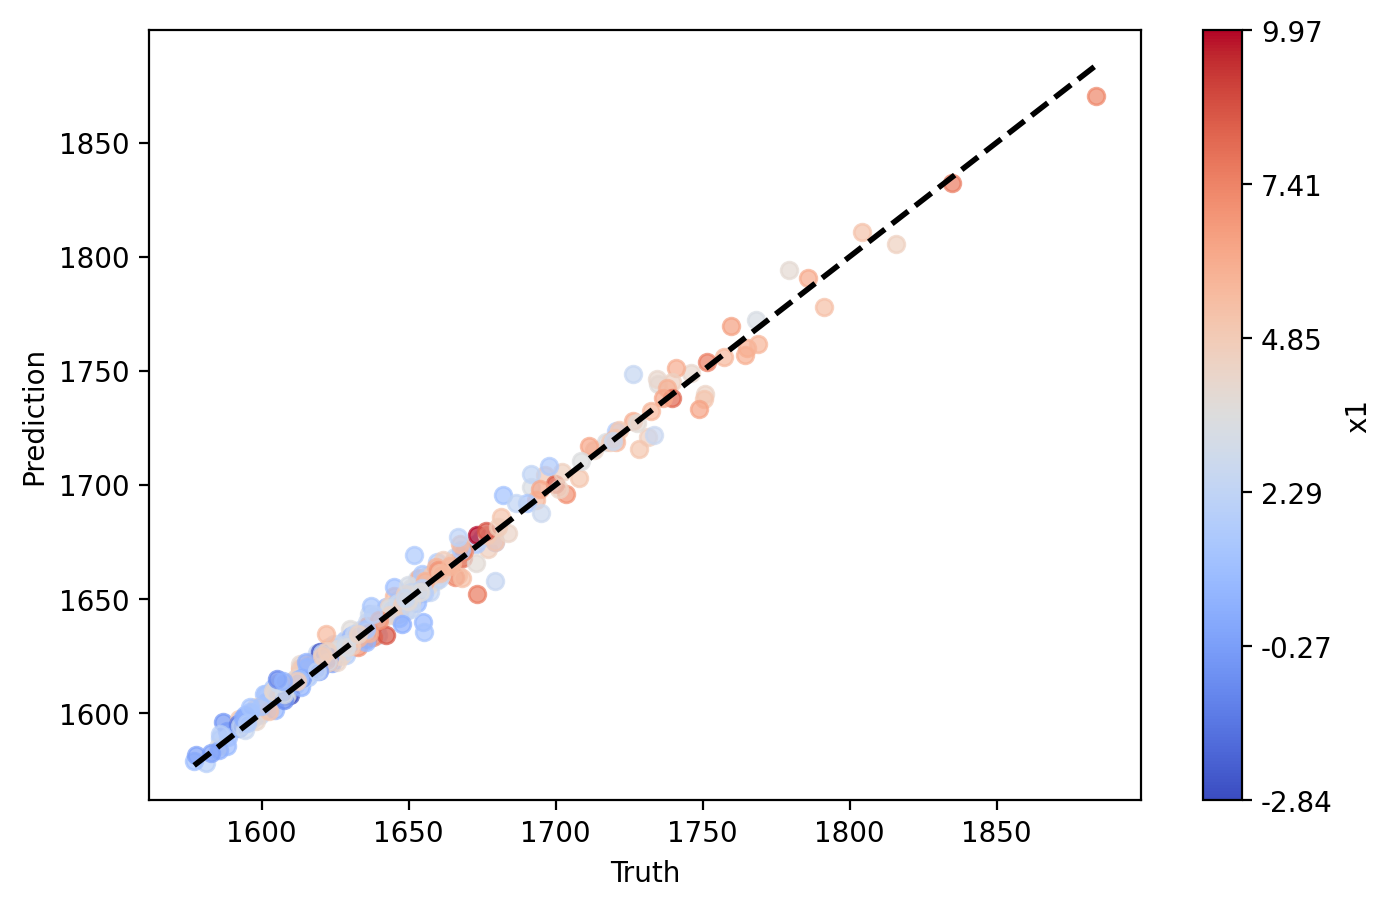

In [32]:
plot_prediction_vs_truth(model,X_test_scaled_sample,X_test_all_sample,y_test_sample,title="")

In [44]:
import torch
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

def ice_plot(model, X_s, X, y, feature_index, feature, num_points=None,off=0,num_of_rounds=5):    
    fig, ax = plt.subplots()

    # Extract the unique feature values from the unscaled data
    feature_values = pd.unique(X.iloc[:, feature_index+off].sort_values())
    feature_values_s = np.unique(np.sort(X_s[:, feature_index]))
    
    # Normalize the CGPA values for coloring
    cgpa_values = X.loc[:, 'x1'].values
    normalized_cgpa = (cgpa_values - np.min(cgpa_values)) / (np.max(cgpa_values) - np.min(cgpa_values))
    cmap = plt.get_cmap('coolwarm')

    # If num_points is specified, select a subset of equally spaced unique feature values
    if num_points is not None:
        idx = np.round(np.linspace(0, len(feature_values) - 1, num_points)).astype(int)
        feature_values = feature_values.iloc[idx]
        feature_values_s = feature_values_s[idx]

    
    
    XXX = X_s.copy()
    predictions_all = []

    # Loop through instances in the test set
    for instance,i in zip(XXX, range(len(X_s))):
        # Create an array to store predictions for this instance
        predictions = []
        mean_ori=0
        for _ in range(num_of_rounds):
            original_prediction = model(torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)).item()
            mean_ori+=original_prediction
        mean_ori=mean_ori/num_of_rounds

        # Loop through the unique feature values
        for val in feature_values_s:
            # Set the feature value for the current instance
            instance[feature_index] = val

            # Convert the instance to a PyTorch tensor and unsqueeze to add batch dimension
            instance_tensor = torch.tensor(instance, dtype=torch.float32).unsqueeze(0).to(device)

            # Get the prediction from the model
            with torch.no_grad():
                mean_pred=0
                for _ in range(num_of_rounds):
                    prediction = model(instance_tensor).item()
                    mean_pred+=prediction
                mean_pred=mean_pred/num_of_rounds
            predictions.append(mean_pred)

        predictions_all.append(predictions)

        # Plot the ICE curve for this instance in the color corresponding to CGPA value with transparency
        plt.plot(feature_values, predictions, color=cmap(normalized_cgpa[i]), alpha=0.5)
        
        # Plot the marker for the original value
        original_val = X.iloc[i, feature_index+off]
        plt.scatter(original_val, mean_ori, marker='o', color=cmap(normalized_cgpa[i]), zorder=10)

    # Calculate the mean of all ICE lines
    mean_predictions = np.mean(predictions_all, axis=0)

    # Plot the mean ICE curve in black and thicker
    plt.plot(feature_values, mean_predictions, color='black', linewidth=2)

    # Label the plot
    plt.xlabel(feature)
    plt.ylabel('Predictions')
    plt.title('ICE plot for {}'.format(feature))
    
    sm = ScalarMappable(cmap=cmap, norm=plt.Normalize(0, 1))
    sm.set_array([])
    
    # Define the colorbar
    cbar = fig.colorbar(sm, ax=ax, orientation='vertical', label='x1')

    # Customize colorbar ticks
    min_val, max_val = np.min(cgpa_values), np.max(cgpa_values)
    tick_values = np.linspace(min_val, max_val, num=6)  # 6 ticks
    normed_ticks = (tick_values - min_val) / (max_val - min_val)  # Normalize tick values (0 to 1 range)
    cbar.set_ticks(normed_ticks)
    
    # Set tick labels with two decimal places
    cbar.set_ticklabels(['{:.2f}'.format(val) for val in tick_values])


    # Show the plot
    plt.show()


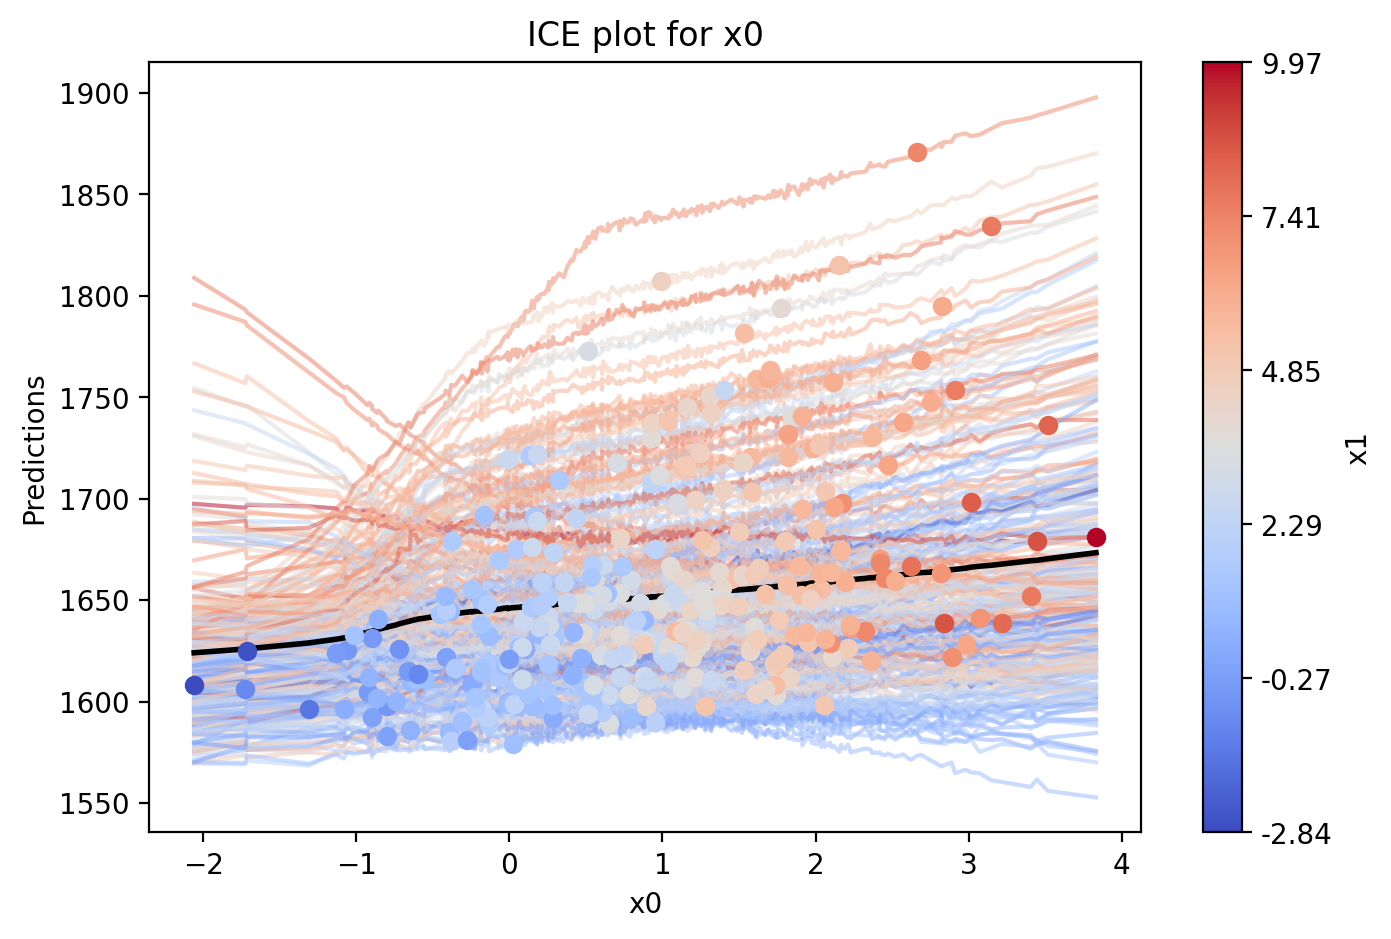

In [47]:
ice_plot(mod.forward, X_test_scaled_sample, X_test_all_sample, y_test_sample,0, 'x0',num_of_rounds=1)

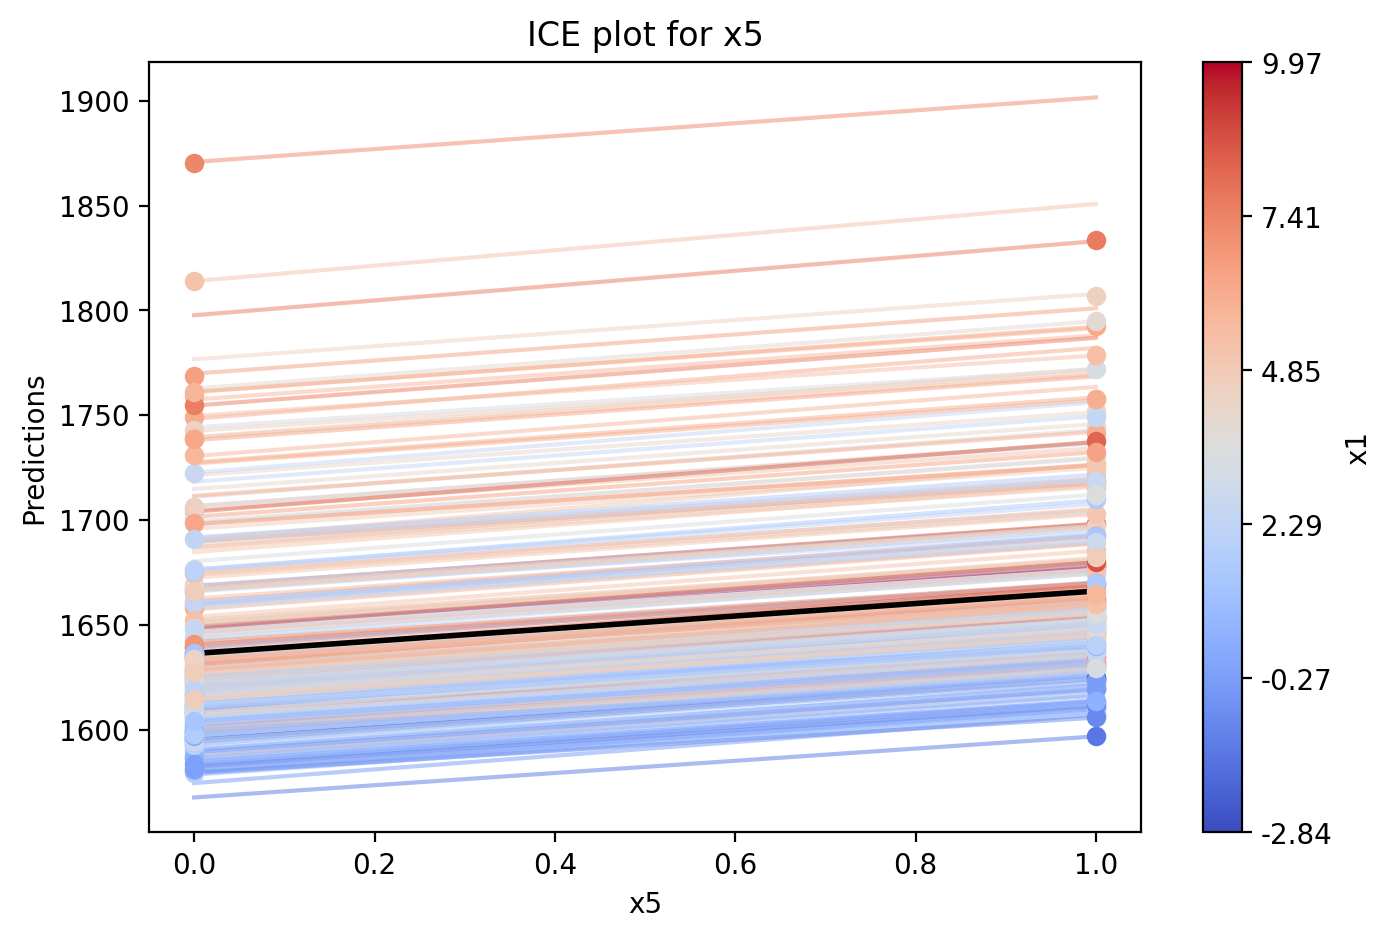

In [48]:
ice_plot(mod.forward, X_test_scaled_sample, X_test_all_sample, y_test_sample,4, 'x5',num_of_rounds=10,off=1)

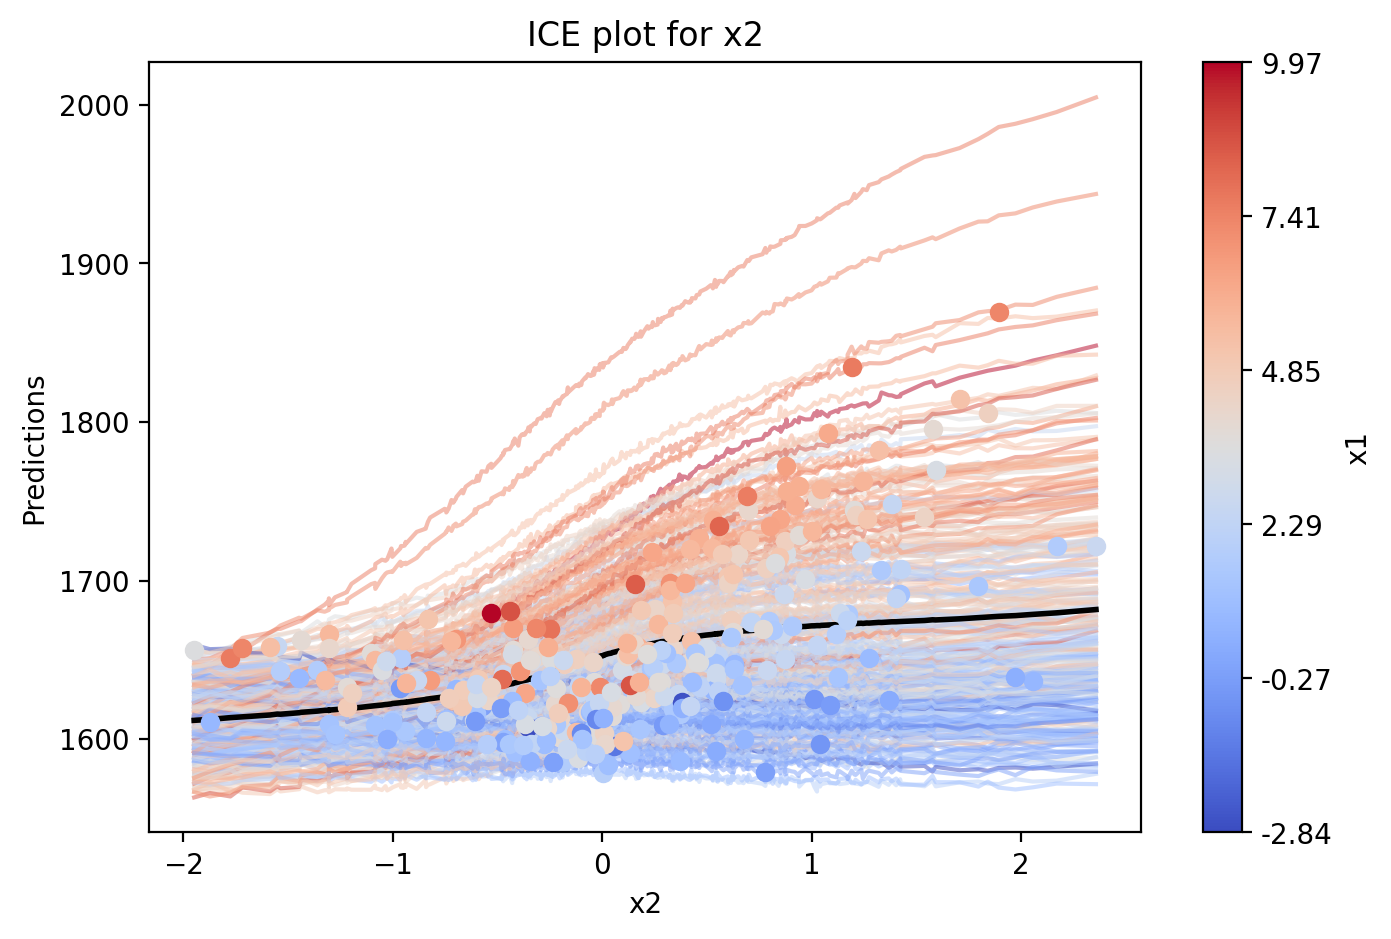

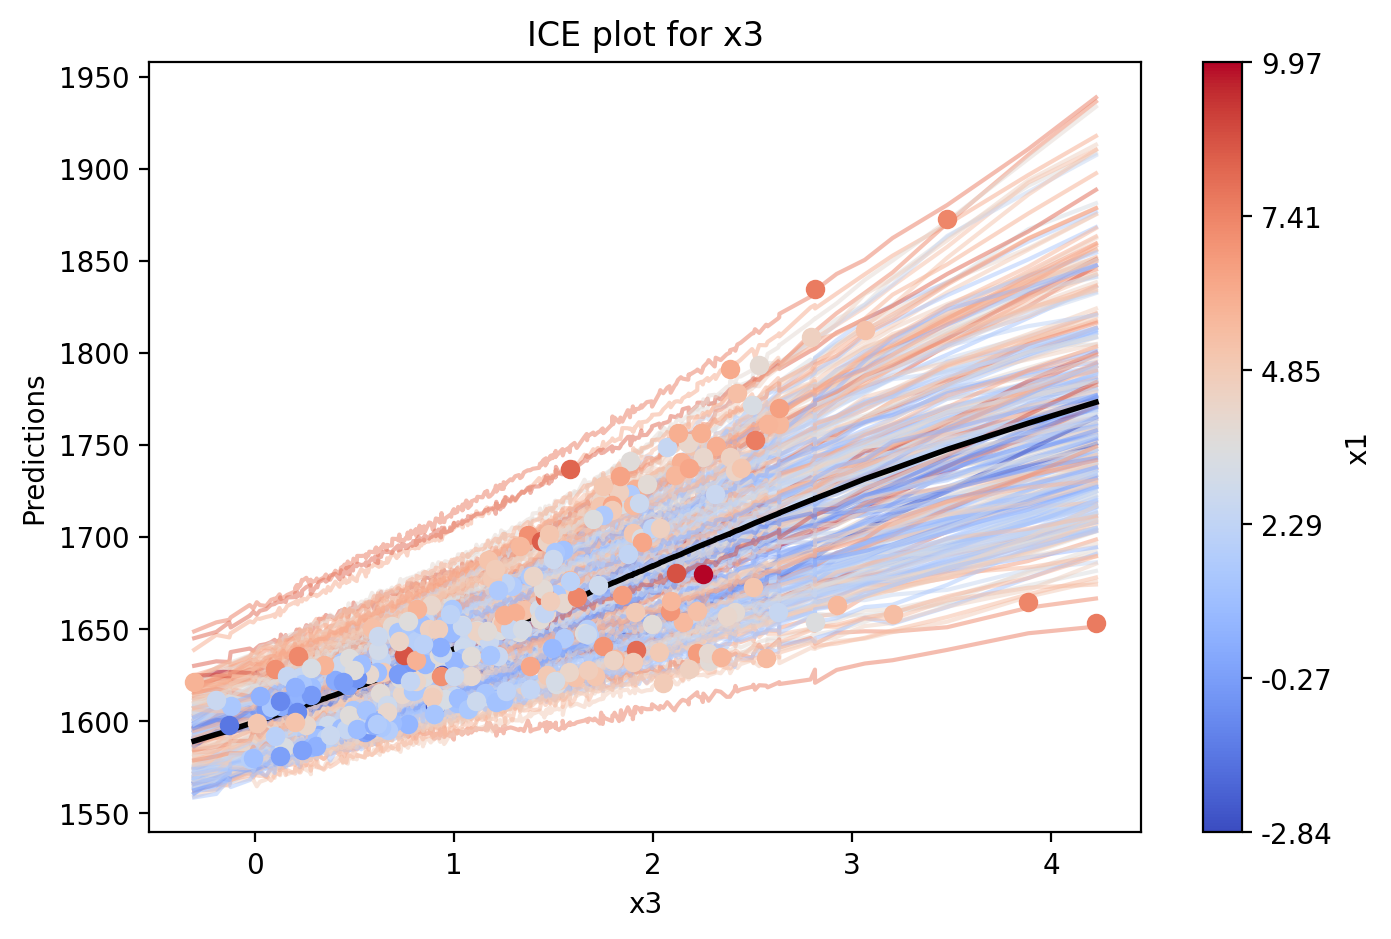

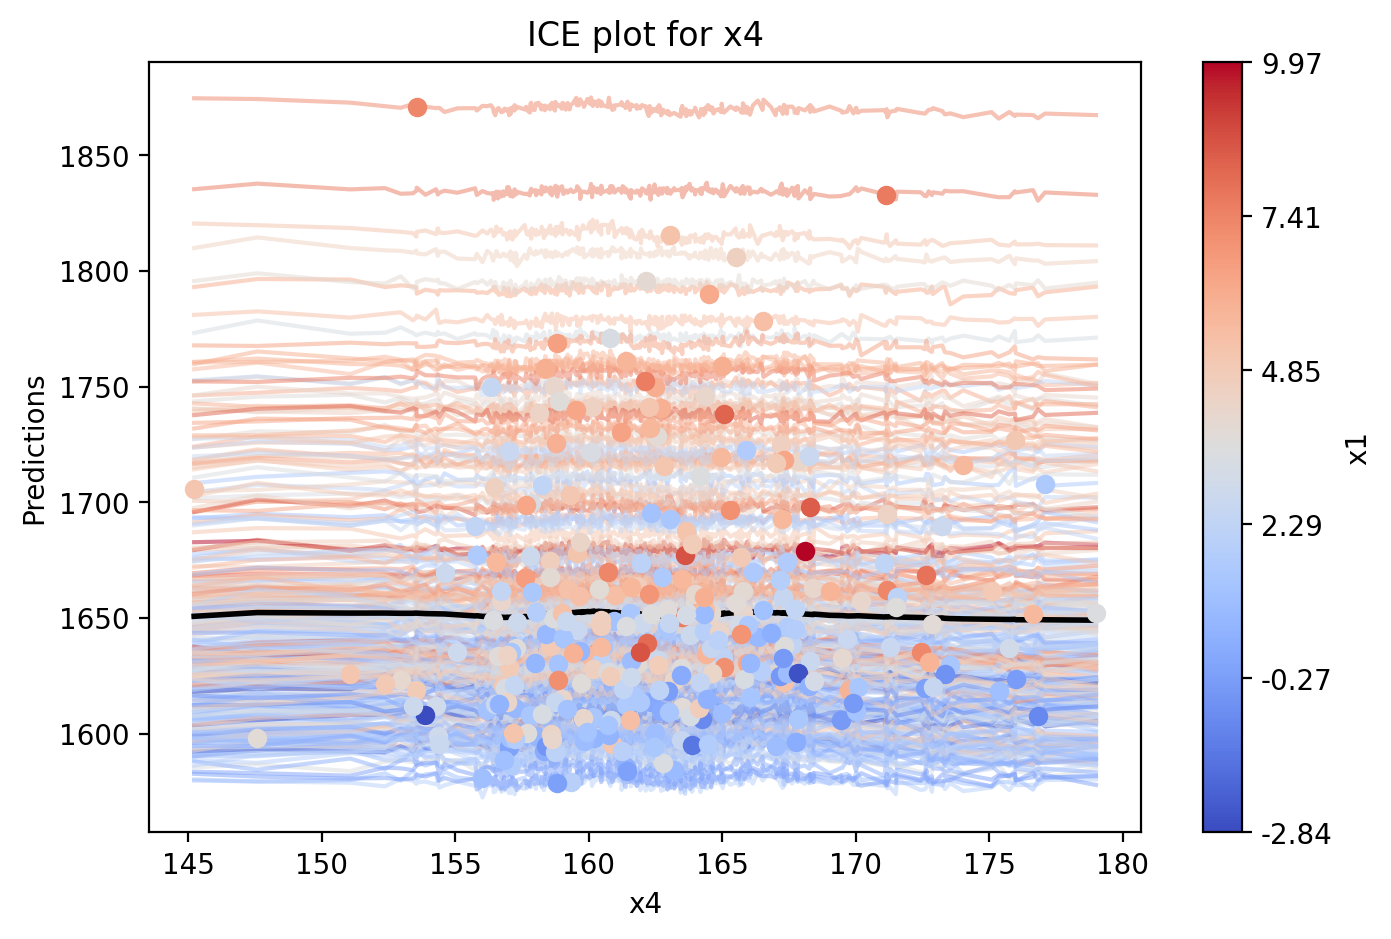

In [49]:
ice_plot(mod.forward, X_test_scaled_sample, X_test_all_sample, y_test_sample,1, 'x2',num_of_rounds=1,off=1)
ice_plot(mod.forward, X_test_scaled_sample, X_test_all_sample, y_test_sample,2, 'x3',num_of_rounds=1,off=1)
ice_plot(mod.forward, X_test_scaled_sample, X_test_all_sample, y_test_sample,3, 'x4',num_of_rounds=1,off=1)


In [75]:
from captum.attr import KernelShap
baseline_unscaled = X_test.mean(axis=0)
baseline_unscaled

x0      1.000645
x1      3.596130
x2      0.001764
x3      1.349328
x4    162.534424
x5      0.499725
dtype: float64

In [76]:
num_runs=100

In [77]:
# Instantiate KernelShap
ks = KernelShap(mod.forward)
worst_shap_values = ks.attribute(worst_instance, baseline_clone,n_samples=30000)
best_shap_values = ks.attribute(best_instance, baseline_clone,n_samples=30000)
baseline_shap_values=ks.attribute(baseline_clone, baseline_clone,n_samples=30000)

In [78]:
worst_shap_np = worst_shap_values.cpu().detach().numpy()
best_shap_np = best_shap_values.cpu().detach().numpy()
import shap
def shap_vis(values,baseline_shap_values,data):
    print(values)
    print(baseline_shap_values)
    print(data)

    # define the corresponding SHAP values
    shap_values = values

    # get the index of the baseline value
    baseline_index = np.argmin(np.abs(shap_values))

    # get the baseline value
    baseline_value = baseline_shap_values

    # create a SHAP Explanation object
    expl = shap.Explanation(values=shap_values,
                        base_values=baseline_value,
                        data=data,
                        feature_names=X_train_con.columns)

    # create a SHAP waterfall plot
    shap.plots.waterfall(expl)

    shap.plots.force(expl)

In [79]:
X_test_sample

x0        x2        x3          x4  x5
87839   2.980198 -0.370338  1.385074  165.939676   0
14037   1.449400  0.426470  1.352234  159.217121   0
6322    1.389094 -0.307353  1.238501  165.777115   1
178520  2.229407 -0.821097  2.223714  160.331000   0
35588   2.170612  0.323352  1.372139  165.309711   1
...          ...       ...       ...         ...  ..
170632  1.816596 -0.948876  2.222765  159.632257   1
139561  2.099128 -0.718956  2.089481  161.583227   1
102025 -0.215859 -0.379728  0.616008  164.462846   0
96558   0.880695 -0.732655  1.672270  160.784784   0
14156  -0.224600 -1.275270  0.899263  160.733020   0

[300 rows x 5 columns]

[ 26.550983   66.359604  139.7475      0.7632179 -33.0316   ]
1667.759521484375
x0      2.663692
x2      1.893728
x3      3.478006
x4    153.564981
x5      0.000000
Name: 23126, dtype: float64


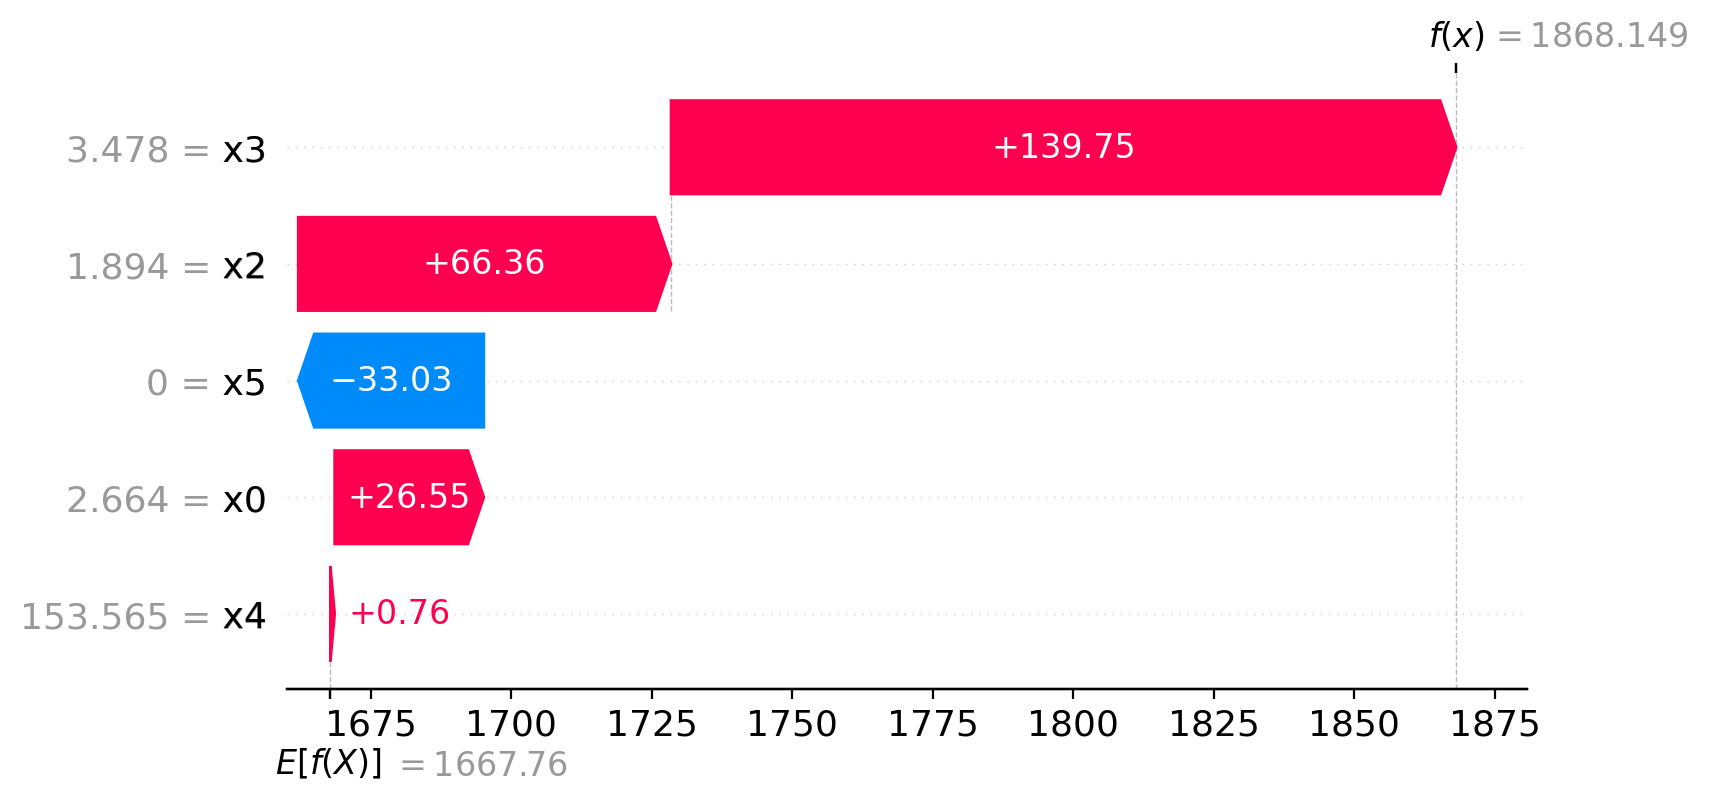

In [80]:
shap_vis(best_shap_np[0],mod.forward(baseline_clone).item(),X_test_sample.iloc[y_test_series.argmax()])

[ -6.224591    -0.3946724  -52.09879     -0.23698807 -28.269077  ]
1669.7249755859375
x0      0.021823
x2      0.029714
x3     -0.006364
x4    156.025954
x5      0.000000
Name: 22115, dtype: float64


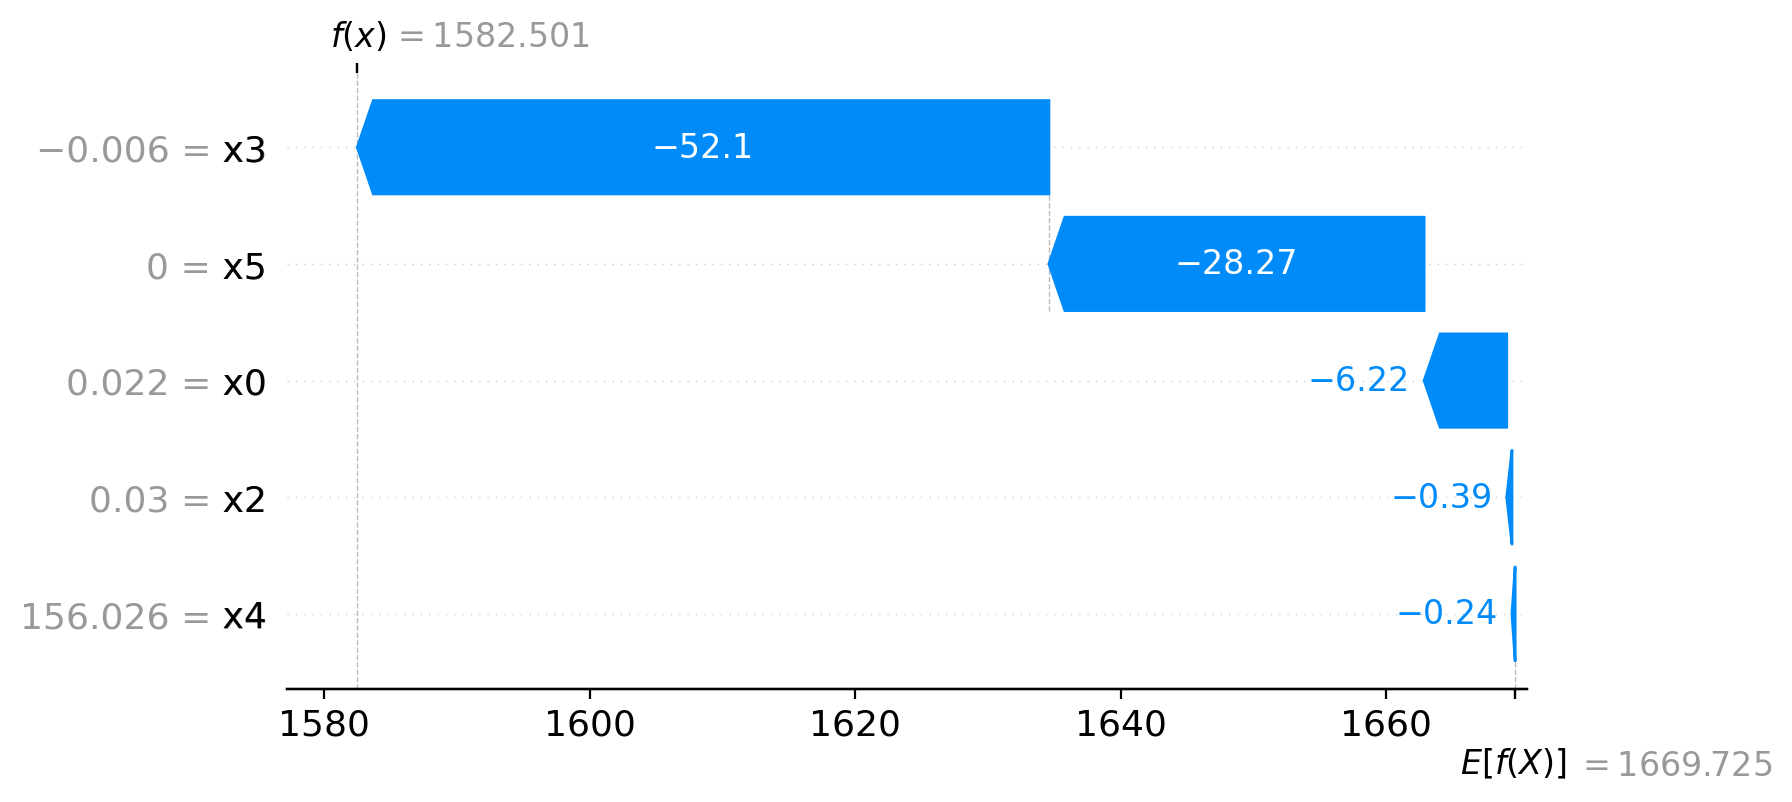

In [81]:
shap_vis(worst_shap_np[0],mod.forward(baseline_clone).item(),X_test_sample.iloc[y_test_series.argmin()])

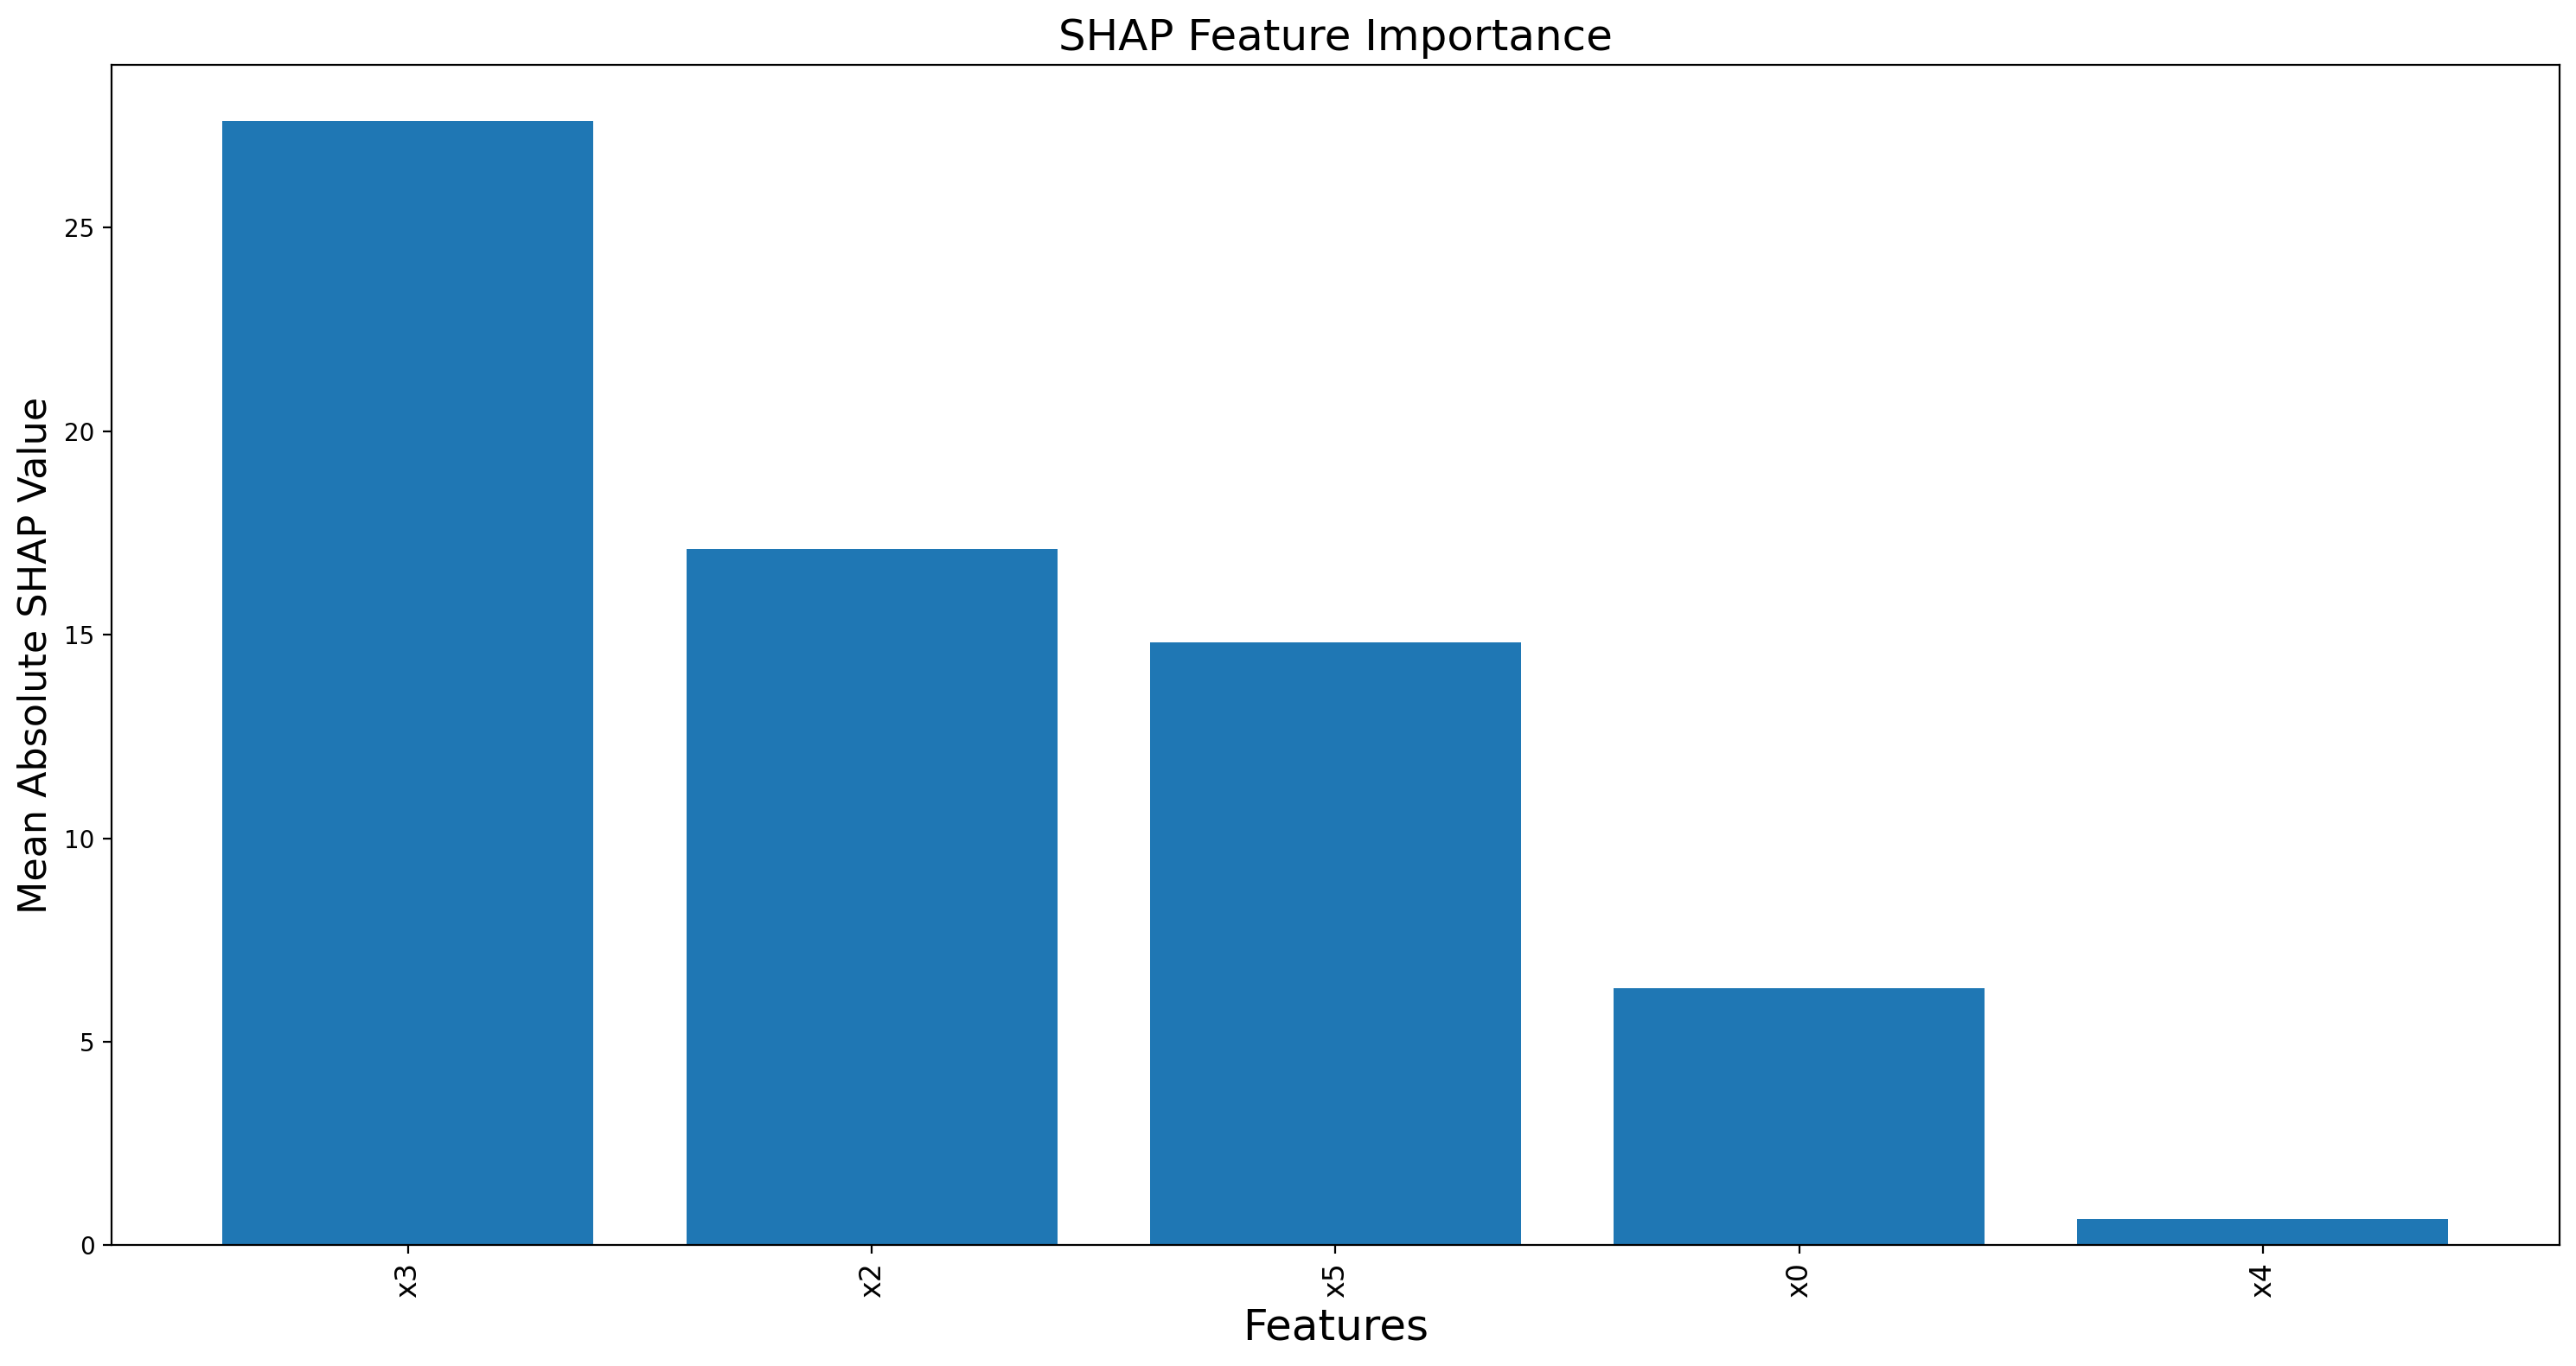

In [86]:
import torch
import numpy as np
from captum.attr import KernelShap
import matplotlib.pyplot as plt

# Instantiate KernelShap
sk = KernelShap(mod.forward)

# Prepare your dataset
# Here, let's assume X_train is your entire dataset
# And that it's a PyTorch Tensor

X_test_t = torch.from_numpy(X_test_scaled_sample)  
# Attribute SHAP values
global_shap_values = []

r_g=5
for instance in X_test_t:
    global_cumulative_shap_values = 0
    for _ in range(r_g):
        shap_values = sk.attribute(instance.unsqueeze(0).float().to(device), baseline_clone,n_samples=200)
        global_cumulative_shap_values+=shap_values
    global_mean_shap_values=global_cumulative_shap_values/r_g
    global_shap_values.append(global_mean_shap_values.detach().cpu().numpy())

global_shap_values = np.array(global_shap_values)
global_shap_values = global_shap_values.reshape(-1, global_shap_values.shape[-1])

# Compute the mean absolute SHAP values for each feature
feature_importance = np.mean(np.abs(global_shap_values), axis=0)

# Sort features by their importance
sorted_indices = np.argsort(feature_importance)[::-1]
sorted_feature_importance = feature_importance[sorted_indices]
sorted_feature_names = X_test_con.columns[sorted_indices]

# Plot the SHAP feature importance
plt.figure(figsize=(15, 8),dpi=200)
plt.bar(sorted_feature_names, sorted_feature_importance)
plt.title('SHAP Feature Importance',fontsize=18)
plt.xlabel('Features',fontsize=18)
plt.ylabel('Mean Absolute SHAP Value',fontsize=16)
plt.xticks(rotation=90,fontsize=12)
plt.tight_layout()
plt.show()


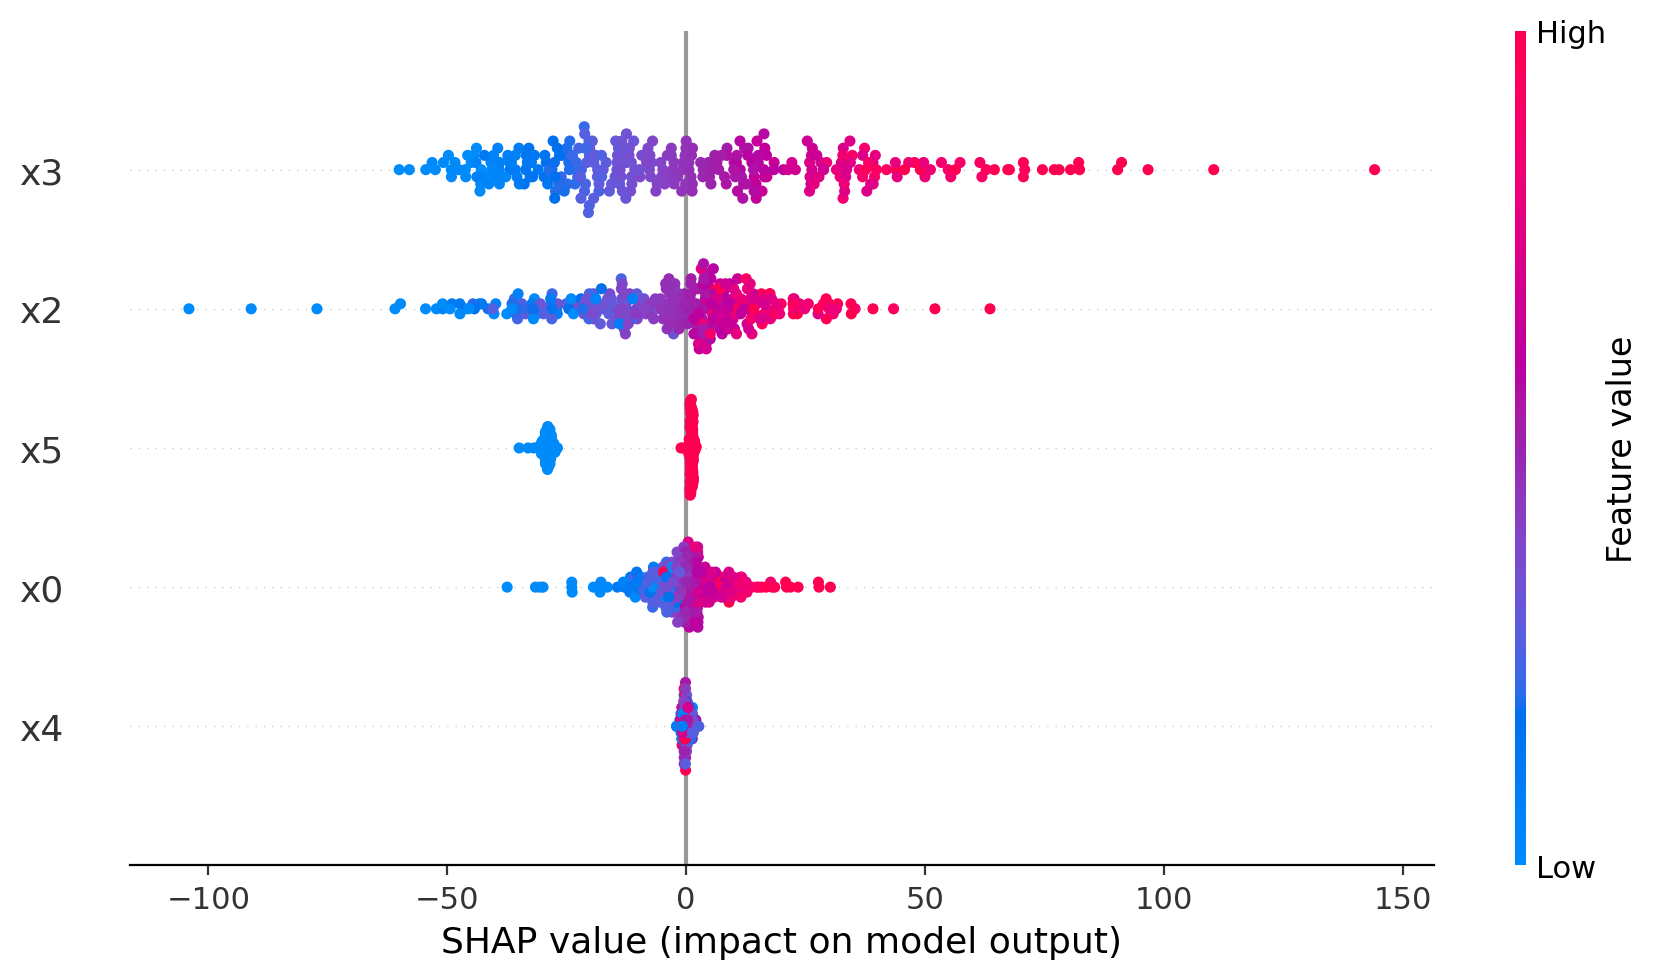

In [88]:
import shap

# Convert the global_shap_values back to a format that shap.summary_plot can understand
global_shap_values = global_shap_values.reshape(global_shap_values.shape[0], -1)

# Create a SHAP summary plot
shap.summary_plot(global_shap_values, X_test_scaled_sample, feature_names=X_test_con.columns,plot_size=(9,5))


In [ ]:
import matplotlib.pyplot as plt
import torch

# Assuming your model is named net_full and your baseline is a tensor
baseline = torch.tensor(X_test_scaled.mean(axis=0)).unsqueeze(0).float().to(device)

# Initialize a list to store the outputs
outputs = []

# Change the 5th value from 0 to 1 in 0.1 steps
for i in torch.arange(-4, 4.1, 0.1):
    baseline_clone = baseline.clone()
    baseline_clone[0][4] = i  # assuming the 5th feature is at index 4 (0-indexed)
    output = mod.forward(baseline_clone)
    outputs.append(output.detach().cpu().numpy().flatten())  # Flatten the output

# Plot the outputs
plt.plot(torch.arange(-4, 4.1, 0.1).numpy(), outputs)
plt.xlabel("5th feature value")
plt.ylabel("Model output")
plt.title("Model output with 5th feature varying from 0 to 1")
plt.grid(True)
plt.show()
